In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!ls 

draft_beam_shape_reconstruction.ipynb
FaisceauDirect_deuxTheta_fente1000um_att90.csv
FaisceauDirect_deuxTheta_fente200um_att90.csv
FaisceauDirect_deuxTheta_fente500um_att90.csv
faisceau_direct_platecolim.ipynb
schema_PlateCollimator.pdf


# Parallel Plate Collimator

## Mesure du faisceau direct avec le collimateur à plaque

et avec le monochromateur hybride en sortie de la source

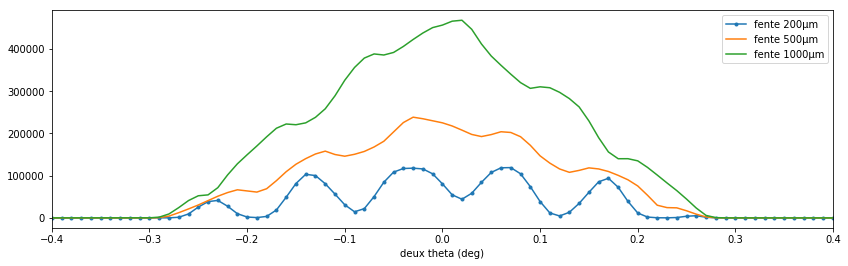

In [6]:
repertoire = './'
data = np.genfromtxt(repertoire+'FaisceauDirect_deuxTheta_fente200um_att90.csv',
                     skip_header=33, delimiter=',')
deux_theta, I_200um = data[:, 0], data[:, 1]

data = np.genfromtxt(repertoire+'FaisceauDirect_deuxTheta_fente500um_att90.csv',
                     skip_header=33, delimiter=',')
deux_theta, I_500um = data[:, 0], data[:, 1]

data = np.genfromtxt(repertoire+'FaisceauDirect_deuxTheta_fente1000um_att90.csv',
                     skip_header=33, delimiter=',')
deux_theta, I_1000um = data[:, 0], data[:, 1]

plt.figure(figsize=(14, 4))
plt.plot(deux_theta, I_200um, '.-', label='fente 200µm');
plt.plot(deux_theta, I_500um, label='fente 500µm');
plt.plot(deux_theta, I_1000um, label='fente 1000µm');
plt.xlabel('deux theta (deg)');  plt.xlim((-0.4, 0.4)); plt.legend();

### Flux en fonction de la largeur d'ouverture

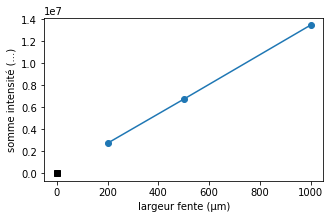

In [7]:
flux = [(200, I_200um.sum()),
         (500, I_500um.sum()),
         (1000, I_1000um.sum())]
plt.figure(figsize=(5, 3))
plt.plot(*zip(*flux), '-o'); plt.xlabel('largeur fente (µm)');   plt.ylabel('somme intensité (...)'); 
plt.plot(0, 0, 'ks');

flux proportionel à l'ouverture => le profil du faisceau est plat...

## Calcul de la transmission à travers le collimateur à fente

Rq: acceptance = demi-angle ??

## Modèle simple

* sans prendre en compte l'épaisseur des lames
* avec un faisceau uniforme et de taille infinie

In [8]:
def transmission(theta, acceptance=0.18):
    ''' Transmission throught the plate collimator 
        acceptance and theta in deg
    '''
    acceptance = acceptance *np.pi/180 # acceptance du collimateur, rad
    theta = np.abs(np.asarray(theta)) *np.pi/180
    t = 1 - np.clip( np.tan(theta)/np.tan(acceptance/2), 0, 1)
    return t

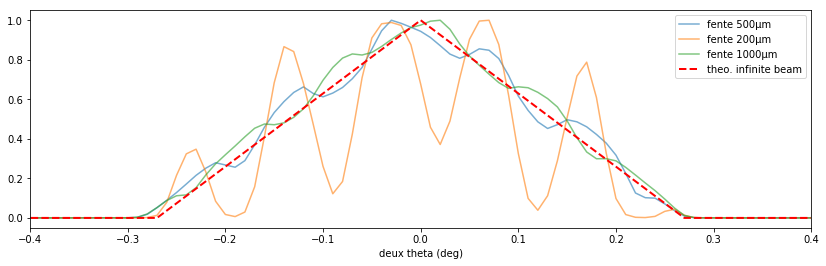

In [9]:
plt.figure(figsize=(14, 4))
plt.plot(deux_theta, I_500um/np.max(I_500um), alpha=0.6, label='fente 500µm');
plt.plot(deux_theta, I_200um/np.max(I_200um), alpha=0.6, label='fente 200µm');
plt.plot(deux_theta, I_1000um/np.max(I_1000um), alpha=0.6, label='fente 1000µm');
# theo
plt.plot(deux_theta, transmission(deux_theta, acceptance=0.27*2),
         '--r', linewidth=2,label='theo. infinite beam');
plt.xlabel('deux theta (deg)'); plt.legend(); plt.xlim((-0.4, 0.4));

## Modèle avec l'épaisseur des lames

* Modèle  avec l'épaisseur des lames
* et l'effet de la taille du faisceau
* faisceau type porte uniforme 

### 1ere version

In [10]:
def is_transmitted(offset, theta): # mm, rad
    theta = np.abs(theta)
    acceptance = 0.27 *np.pi/180  # demi angle
    L = 95 # mm
    h = 0.1 # mm, plate thickness
    gap = L*np.tan(acceptance)
    
    periode = (h+gap) * np.cos(theta)
    shaddow = L*np.sin(theta) + h*np.cos(theta)
    
    return (offset % periode)>shaddow

In [11]:
beam_width = 200e-3 # mm
R_collim = 260 # mm, distance centre gonio --> plate collimator

deuxtheta_mesh = np.linspace(-.3, .3, 851) *np.pi/180

# Convolution avec le faisceau
t = np.zeros_like(deuxtheta_mesh)
for beam_offset in np.linspace(-beam_width/2, +beam_width/2, 301):
    offset = R_collim * deuxtheta_mesh + beam_offset # mm 
    t += is_transmitted(offset, deuxtheta_mesh)
    
t = t/t.max()

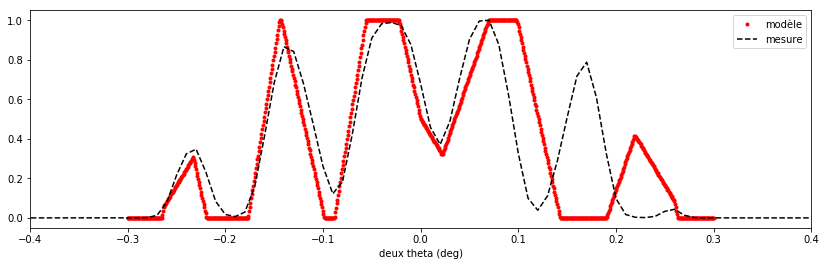

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(deuxtheta_mesh*180/np.pi, t, '.r', label='modèle');
plt.plot(deux_theta, I_200um/np.max(I_200um), '--k', label='mesure');
plt.xlim((-0.4, 0.4)); plt.legend(); plt.xlabel('deux theta (deg)'); 

### Seconde version du calcul

voir le [schéma](./schema_PlateCollimator.pdf)

In [13]:
# non utilisé:
def intervalles_old(theta, geom, z0=0):
    L, gap, plate, R = geom
    
    theta = np.abs( np.asarray(theta) )
    
    shadow = L*np.sin(theta) + plate*np.cos(theta)
    period = (gap + plate)*np.cos(theta)
    through = (period - shadow).clip(0, period)
    
    offset = theta*R + z0
    return period, through, offset

In [14]:
def through_start_end(theta, geom, z0=0):
    ''' altitude du début et de la fin de la zone passante pour la lumière
        relativement au milieu de l'épaisseur de la lame solide
    '''
    L, gap, plate, R = geom
    
    theta =  np.asarray(theta) 
    
    #shadow = L*np.sin(theta) + plate*np.cos(theta)
    period = (gap + plate)*np.cos(theta)
    #through = (period - shadow).clip(0, period)
    if np.abs(np.tan(theta)) >= gap/L:
        return period, 0, 0, 0
    elif theta>0:
        through_start = plate/2*np.cos(theta) + L*np.sin(theta)
        through_end = period - plate/2*np.cos(theta) 
    else:
        through_start = plate/2*np.cos(theta) 
        through_end = period - plate/2*np.cos(theta) + L*np.sin(theta)
        
    offset = theta*R + z0
    return period, through_start, through_end, offset

In [14]:
def overlap(beam, slit):
    ''' Donne la longueur de l'overlap entre les deux intervalles
        et 0 si il n'y a pas d'overlap, ou intervals négatifs
    '''
    slit_start, slit_end = slit
    beam_start, beam_end = beam
    
    diff = np.minimum(beam_end, slit_end) - np.maximum(slit_start, beam_start)
    overlap = np.maximum(diff, 0)

    return overlap

In [15]:
def transmittance(theta, beam_edges, geom, i_max=20):
    ''' Somme sur les différente gap/lames l'intenisité du faisceau passant
    '''
    #period, through, offset = intervalles(theta, geom, z0=0)
    period, start_through, end_through, offset = through_start_end(theta, geom, z0=0)
    
    i_range = np.arange(-i_max, +i_max+1)
    slit_starts = i_range*period + offset + start_through
    slit_ends = i_range*period + offset + end_through
    
    return overlap(beam_edges, (slit_starts, slit_ends)).sum()

def transmittance_vector(theta, beam_edges, geom, i_max=19):
    '''De même mais vectorisé'''
    t_theo = [transmittance(angle, beam_edges, geom, i_max=i_max)
              for angle in theta]
    t_theo = np.asarray(t_theo)
    t_theo = t_theo/t_theo.max()
    return t_theo

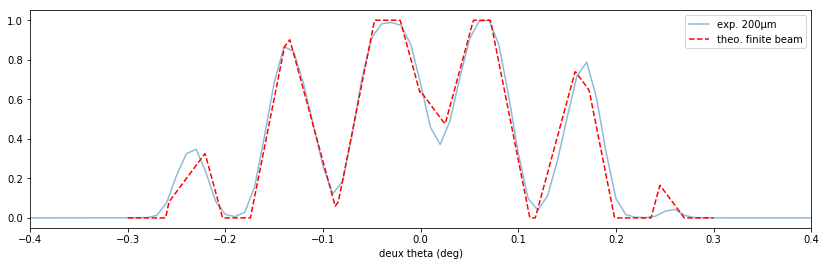

In [16]:
acceptance = 0.27 *np.pi/180  # rad, demi angle
plate_length = 95 # mm
plate_thickness = 0.09 # mm, plate thickness
gap = plate_length*np.tan(acceptance)

R = 260 # mm, 
geom = plate_length, gap, plate_thickness, R

beam_edges = np.array([-0.1, 0.15]) + .05

theta = np.linspace(-0.3, 0.3, 851) * np.pi/180
t_theo = transmittance_vector(theta, beam_edges, geom, i_max=28)

plt.figure(figsize=(14, 4))
#plt.plot(deux_theta, I_500um/np.max(I_500um), alpha=0.5, label='exp. 500µm');
plt.plot(deux_theta, I_200um/np.max(I_200um), alpha=0.5, label='exp. 200µm');
plt.plot(theta*180/np.pi, t_theo, '--r', label='theo. finite beam');
plt.xlabel('deux theta (deg)'); plt.legend(); plt.xlim((-0.4, 0.4));

## Tentatives optimisation des paramètres

In [17]:
def get_error(x):
    Iexp = I_200um
    theta = deux_theta * np.pi/180

    beam_edges = x[:2]
    geom = x[2:]
    t_theo = transmittance_vector(theta, beam_edges, geom, i_max=10)
    return np.sum( (t_theo - Iexp)**2 )

In [18]:
import itertools as it
from scipy.optimize import minimize

In [19]:
ranges = [np.linspace(-0.2, 0., 15), # beam start
          np.linspace(0.1, 0.22, 15), # beam end
          (95, ), # length
          (gap, ), # gap
          (0.07, ), # thickness
          (260, )] # R

print('nbr evaluations:', np.prod( [len(u) for u in ranges] ))

nbr evaluations: 225


In [20]:
res = []
for params in it.product(*ranges):
    #r = minimize(get_error, params, method='Nelder-Mead')
    res.append( (params, get_error(params)) )

print(len(res))

top_res = sorted(res, key=lambda x:x[1])[:3]
top_res

225


[((0.0, 0.12571428571428572, 95, 0.4476802669618013, 0.07, 260),
  227949580813.88165),
 ((0.0, 0.10857142857142858, 95, 0.4476802669618013, 0.07, 260),
  227949583819.55246),
 ((0.0, 0.13428571428571429, 95, 0.4476802669618013, 0.07, 260),
  227949584787.84387)]

In [ ]:
x = top_res[0][0]
beam_edges = x[:2]
geom = x[2:]
t_theo = transmittance_vector(theta, beam_edges, geom, i_max=15)

plt.figure(figsize=(14, 4))
#plt.plot(deux_theta, I_500um/np.max(I_500um), alpha=0.5, label='exp. 500µm');
plt.plot(deux_theta, I_200um/np.max(I_200um), alpha=0.5, label='exp. 200µm');
plt.plot(theta*180/np.pi, t_theo, '--r', label='theo. finite beam');
plt.xlabel('deux theta (deg)'); plt.legend(); plt.xlim((-0.4, 0.4));

In [ ]:
geom

In [ ]:
ranges = [np.linspace(-0.1, 0.1, 15) - 0.15, # beam start  np.array([-0.1, 0.15]) + .05
          (0.20, ), # beam end
          (95, ), # length
          (gap, ), # gap
          (0.075, ), # thickness
          (260, )] # R

res = []
for params in it.product(*ranges):
    #r = minimize(get_error, params, method='Nelder-Mead')
    res.append( (params, get_error(params)) )

print(len(res))

In [ ]:
plt.plot([x[0][0] for x in res], [x[1] for x in res])

In [ ]:
# Opti. plate thick
param_span = np.linspace(0.05, 0.5, 70)
errors = [get_error(I_200um, theta, beam_edges, (plate_length, gap, plate_thickness, R))
                for plate_thickness in param_span]
plt.plot(param_span, errors);
print('offset min:', param_span[np.argmin(errors)])

In [ ]:
# Opti. offset
offset_span = np.linspace(-0.2, 0.2, 70)
error_offset = [get_error(I_200um, theta, beam_edges+offset, geom)
                for offset in offset_span]
plt.plot(offset_span, error_offset);
print('offset min:', offset_span[np.argmin(error_offset)])

In [ ]:
# Opti. beam start - end
param_span = np.linspace(-0.05, 0.15, 80)
errors = [get_error(I_200um, theta, np.array((-0.0892, beam_start)) - 0.0632, geom)
                for beam_start in param_span]
plt.plot(param_span, errors);
print('param min:', param_span[np.argmin(errors)])

In [ ]:
plt.figure(figsize=(14, 4))
#plt.plot(deux_theta, I_500um/np.max(I_500um), alpha=0.5, label='exp. 500µm');
plt.plot(deux_theta, I_200um/np.max(I_200um), alpha=0.5, label='exp. 200µm');
plt.plot(deux_theta, t_theo, '--r', label='theo. finite beam');
plt.xlabel('deux theta (deg)'); plt.legend(); plt.xlim((-0.4, 0.4));

In [ ]:
gap